# Indexation Web - TP1
BERNARD Renan

## Introduction

Tout d'abord les différentes importations nécessaires pour ce Notebook.
Les fonctions utilisées sont dans le fichier __utils.py__.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from functools import reduce
import multiprocessing

from utils import *

[nltk_data] Downloading package stopwords to /home/renan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Récupérons ensuite l'ensemble des données. Nous garderons un DataFrame contenons le texte, l'auteur et l'identifiant du document.

In [3]:
%%time
texts = generate_texts_dataframe()
texts.head()

CPU times: user 207 ms, sys: 83.3 ms, total: 290 ms
Wall time: 594 ms


,Text,Author,DocumentId
0,"Russia's Fuel and Energy Ministry, sitting on ...",Lynnley Browning,116673
1,Russia's Western oil joint ventures are findin...,Lynnley Browning,248885
2,Russian oil company officials said on Friday t...,Lynnley Browning,314644
3,Azerbaijan is proving more successful in attra...,Lynnley Browning,219830
4,A multinational group trying to build a $1.5 b...,Lynnley Browning,239689


Lisons un article :

In [4]:
view_article(504, texts)


--------------------------------------------
Author : Jo Winterbottom
Id : 103362
--------------------------------------------
British utilities could find share buybacks and takeovers more costly as the government ruled out tax credits on buybacks and some special dividends on Tuesday, analysts said, but they are unlikely to stop such moves.
"It should not stop companies doing buybacks or special dividends," said Michael Cohen, utilities analyst at Salomon Brothers, "those should still go ahead if justified."
Chancellor Kenneth Clarke said shareholders would no longer be able to claim tax credits on share buybacks or special dividends associated with share consolidations or takeovers.  
The move is a means of giving the UK Treasury more room for a cut in income tax in its November budget, analysts said.
Shares in the utility sector, which has seen a steady flow of buybacks and special dividends both within and outside the context of takeovers, initially slumped on the news but later 

## Préparation des Textes - _Tokenization_

Le premier traitement est la transformation des phrases en une liste de mots contenant uniquement des caractères alphabétiques minuscules extraits à l'aide d'une expression régulière.

On enlève ensuite les 'stopWords' (_the_, _a_, _or_,...) qui n'apportent pas d'information sur le contenu de l'article.

Puis on a choisi d'utiliser un __stemmer__ pour transformer les mots en _tokens_. Cette méthode enlève les préfixes et suffixes des mots pour garder uniquement la racine. Celle-ci n'est pas forcement un mot qui existe réellement comme _ministri_, mais capte l'ensemble des mots "proches".

C'est la fonction __tokenize_text__ qui fait cette étape. Elle est présente dans __utils.py__.

La suite du traitement de texte se fera via ces listes de _tokens_.

## Indexation

### Création de l'Index

Afin de trouver rapidement les documents qui contiennent un certain _token_, nous créons un index. On a choisi de faire un index de la forme suivante :

    {"token1" : {"total_occurences" : 4, 

             article1 : {"locations" : [12, 13, 14], 
             
                         "occurences" : 3}, 
                         
             article2 : {"locations" : [9], 
             
                         "occurences" : 1}}} 

La création de l'index pour un seul texte se fait via la fonction __create_index_from_text__. Celle-ci procède via une itération sur la liste de _tokens_ correspondant au texte pour ensuite enregistrer le nombre d'occurences des _tokens_ dans un index selon le modèle précédent.

La création de l'index final se fait alors en "additionant" les différents index via la foncion __sum_two_indexes__.
                               
Tout d'abord, regardons le temps d'exécution et le résultat via une itération sur l'ensemble des documents :

In [5]:
%%time
index = create_index_from_text(texts.Text[0], 0)
for i in range(1, len(texts)):
    index_i = create_index_from_text(texts.Text[i], i)
    index = sum_two_indexes(index, index_i)

CPU times: user 21.2 s, sys: 158 ms, total: 21.3 s
Wall time: 21.4 s


In [6]:
index['ministri']

{'total_occurences': 361,
 0: {'locations': [3, 64, 104, 146, 154, 197, 228, 315, 344, 352],
  'occurences': 10},
 2: {'locations': [91, 108], 'occurences': 2},
 3: {'locations': [228, 245], 'occurences': 2},
 7: {'locations': [142], 'occurences': 1},
 12: {'locations': [212], 'occurences': 1},
 13: {'locations': [2, 35, 60], 'occurences': 3},
 14: {'locations': [170, 269], 'occurences': 2},
 16: {'locations': [212, 295], 'occurences': 2},
 23: {'locations': [11, 55, 200, 203, 250], 'occurences': 5},
 25: {'locations': [233, 296, 311, 329], 'occurences': 4},
 26: {'locations': [142], 'occurences': 1},
 32: {'locations': [329], 'occurences': 1},
 33: {'locations': [115], 'occurences': 1},
 37: {'locations': [130, 228, 311], 'occurences': 3},
 41: {'locations': [30, 65, 77], 'occurences': 3},
 45: {'locations': [98], 'occurences': 1},
 46: {'locations': [226, 244], 'occurences': 2},
 47: {'locations': [130], 'occurences': 1},
 48: {'locations': [129], 'occurences': 1},
 82: {'locations':

Maintenant essayons avec l'architecture __MapReduce__, le _mapper_ correspondant à la création de l'index sur un seul text, le _reducer_ correspondant à la somme de deux index.

In [7]:
%%time 
def mapper(x):
    return create_index_from_text(texts.Text[x], x)

with multiprocessing.Pool(processes=8) as pool:
        results = pool.map(mapper, range(len(texts)))
        
index = reduce(sum_two_indexes, list(results))

CPU times: user 3.25 s, sys: 350 ms, total: 3.6 s
Wall time: 13.9 s


In [8]:
index['ministri']

{'total_occurences': 361,
 0: {'locations': [3, 64, 104, 146, 154, 197, 228, 315, 344, 352],
  'occurences': 10},
 2: {'locations': [91, 108], 'occurences': 2},
 3: {'locations': [228, 245], 'occurences': 2},
 7: {'locations': [142], 'occurences': 1},
 12: {'locations': [212], 'occurences': 1},
 13: {'locations': [2, 35, 60], 'occurences': 3},
 14: {'locations': [170, 269], 'occurences': 2},
 16: {'locations': [212, 295], 'occurences': 2},
 23: {'locations': [11, 55, 200, 203, 250], 'occurences': 5},
 25: {'locations': [233, 296, 311, 329], 'occurences': 4},
 26: {'locations': [142], 'occurences': 1},
 32: {'locations': [329], 'occurences': 1},
 33: {'locations': [115], 'occurences': 1},
 37: {'locations': [130, 228, 311], 'occurences': 3},
 41: {'locations': [30, 65, 77], 'occurences': 3},
 45: {'locations': [98], 'occurences': 1},
 46: {'locations': [226, 244], 'occurences': 2},
 47: {'locations': [130], 'occurences': 1},
 48: {'locations': [129], 'occurences': 1},
 82: {'locations':

Les résultats sont heureusement les mêmes, mais l'utilisation de __map__ et __reduce__ divise par quasiment 2 le temps de calcul (en fonction de la RAM de la machine, on peut augmenter le nombre de _processes_).

### Etude du Vocabulaire

In [9]:
%%time

def mapper(token):
    return {"Token" : token, "Occurences" : index[token]["total_occurences"]}

with multiprocessing.Pool(processes=4) as pool:
        results = pool.map(mapper, list(index.keys()))
        
df_vocabulary = pd.DataFrame(list(results)).sort_values("Occurences", ascending=False)

CPU times: user 120 ms, sys: 297 ms, total: 417 ms
Wall time: 606 ms


In [10]:
len(df_vocabulary)

18438

In [11]:
df_vocabulary.head(10)

,Token,Occurences
17,said,19856
277,year,7025
79,compani,5658
304,percent,5296
375,would,5202
349,million,4981
14,market,4719
16,analyst,4048
280,share,3641
13,new,3547


Le _token_ le plus utilisé dans le corpus est __said__, puis __year__. Ces mots auraient pû être considérés comme des __stopWords__ (non-porteurs de sens) vu leur fréquence.

La loi de __Zipf__ est-elle vérifiée dans notre corpus ?

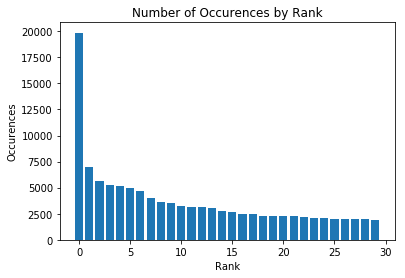

In [12]:
plt.bar(x=range(30), height=df_vocabulary.Occurences[:30])
plt.xlabel("Rank")
plt.ylabel("Occurences")
plt.title("Number of Occurences by Rank")
plt.show()

On peut voir la loi de __Zipf__ si on veut la voir. Le corpus étant d'une taille assez limitée (2500 textes), on peut supposer qu'il est normal d'avoir quelque chose de proche. Il est aussi important de rappeler que nous travaillons sur des _tokens_ et non des mots !

## _Ranking_ par occurences

Tout d'abord un schéma de requêtes simples : pour une phrase ou un mot, les documents sont ordonnées par leur nombre de _tokens_ total. Pour la requête __"china"__, les documents seront classés par leur nombre d'occurences du _token_ __china__. Pour la requête __"china and russia were communist"__, les documents seront classés par leur nombre d'occurences total des _tokens_ __china__, __russia__ et __communist__.

In [13]:
query = "china"
query_by_occurences(query, index, texts).head()

,china,Total,Text,Author,DocumentId
1565,26,26.0,While China's leaders peppered 1996 with assur...,Lynne Donnell,275670
2294,24,24.0,"Now that China's Deng Xiaoping is dead, Hong K...",Sarah Davison,405565
170,21,21.0,More foreign firms are finally beginning to re...,Graham Earnshaw,277010
1198,20,20.0,China is unlikely to concede on its demand to ...,Jane Macartney,242319
1150,20,20.0,China is unlikely to concede on its demand to ...,Jane Macartney,242519


In [14]:
query = "air cargo"
df_occ = query_by_occurences(query, index, texts)
df_occ.head()

,air,cargo,Total,Text,Author,DocumentId
1330,12,25,37.0,This is Reuters' 2nd ex-Hong Kong air cargo ma...,Jim Gilchrist,126597
1305,10,22,32.0,Demand for space has eased slightly as a recen...,Jim Gilchrist,123461
1328,6,10,16.0,Hong Kong Air Cargo Terminals Limited (HACTL) ...,Jim Gilchrist,133504
1347,12,3,15.0,An American airline has successfully completed...,Jim Gilchrist,206567
1306,5,10,15.0,Major airlines operating cargo flights to Euro...,Jim Gilchrist,156695


In [15]:
len(df_occ)

58

Maintenant plus compliqué : repondons à une requête en respectant l'ordre des mots, les résutats seront classés de la même manière que les requêtes précédentes.

In [16]:
%%time
query = "air cargo"
df_ordered_occ = query_by_ordered_occurences(query, index, texts)
df_ordered_occ.head()

CPU times: user 37.4 ms, sys: 61 µs, total: 37.5 ms
Wall time: 34.8 ms


,Occurences,Text,Author,DocumentId
1330,7,This is Reuters' 2nd ex-Hong Kong air cargo ma...,Jim Gilchrist,126597
1305,5,Demand for space has eased slightly as a recen...,Jim Gilchrist,123461
1328,4,Hong Kong Air Cargo Terminals Limited (HACTL) ...,Jim Gilchrist,133504
1325,3,The Hong Kong Shippers' Council is urging the ...,Jim Gilchrist,186190
1337,3,Hong Kong civil aviation department statistics...,Jim Gilchrist,123517


In [17]:
len(df_ordered_occ)

50

In [18]:
%%time
query = "cargo air"
query_by_ordered_occurences(query, index, texts).head()

CPU times: user 37.4 ms, sys: 0 ns, total: 37.4 ms
Wall time: 36.6 ms


,Occurences,Text,Author,DocumentId
1306,1,Major airlines operating cargo flights to Euro...,Jim Gilchrist,156695


## _Ranking_ par Fréquences

Passons à un schéma de requêtes plus cohérent : en utilisant la fréquence des mots au sein d'un document.

In [19]:
%%time
query = "air cargo"
df_freq = query_by_frequences(query, index, texts)
df_freq.head()

CPU times: user 356 ms, sys: 3.77 ms, total: 359 ms
Wall time: 359 ms


,air,cargo,Total,Text,Author,DocumentId
1337,0.0441176,0.0588235,0.102941,Hong Kong civil aviation department statistics...,Jim Gilchrist,123517
1336,0.0384615,0.0512821,0.089744,Freight forwarders in Hong Kong say they have ...,Jim Gilchrist,11270
1307,0.0212766,0.0638298,0.085106,Korean Air Lines Ltd's cargo load factor dropp...,Jim Gilchrist,21567
1340,0.0294118,0.0441176,0.073529,Hong Kong civil aviation department statistics...,Jim Gilchrist,123524
1345,0.0309278,0.0360825,0.067010,Air Macau said it expects to carry beween 20 a...,Jim Gilchrist,108091


## _Ranking_ par TF-IDF

## Métrique TF-IDF

t = term, D = corpus

$|d|$ : taille de l'article

$N_{t,d}=  \# \{t \epsilon d\}$ 

$f_{t,d} = \frac{N_{t,d}}{|d|}$

$|D|$ : taille du corpus

$N_t = \# \{d \epsilon D / t \epsilon  d \}$

$IDF_t = log(\frac{|D|}{1 + N_t})$

$TF-IDF_{t,d} = f_{t,d} * IDF_t$


In [20]:
%%time
query = "air cargo"
df = query_by_tfidf(query, index, texts)
df.head()

CPU times: user 461 ms, sys: 0 ns, total: 461 ms
Wall time: 461 ms


,air,cargo,Total,Text,Author,DocumentId
1337,0.151159,0.162983,0.314143,Hong Kong civil aviation department statistics...,Jim Gilchrist,123517
1336,0.13178,0.142088,0.273868,Freight forwarders in Hong Kong say they have ...,Jim Gilchrist,11270
1307,0.0728995,0.176854,0.249754,Korean Air Lines Ltd's cargo load factor dropp...,Jim Gilchrist,21567
1340,0.100773,0.122237,0.223010,Hong Kong civil aviation department statistics...,Jim Gilchrist,123524
1345,0.105967,0.0999743,0.205942,Air Macau said it expects to carry beween 20 a...,Jim Gilchrist,108091


## Représentation vectorielle avec TF-IFD

La matrice TF_IDF est la représation du corpus dans l'espace TF-IDF.

In [21]:
%%time
tf_idf_matrix = calculate_tf_idf_matrix(index, texts)

CPU times: user 749 ms, sys: 204 ms, total: 952 ms
Wall time: 973 ms


### Mise en place d'une requête du corpus

Pour requêter (_query_) le corpus, nous calculons simplement le produit scalaire (_dot product_) de la représentation du texte de la requête dans l'espace TF-IDF par la matrice correspondant aux repréentations des documents. Le document dont le _dot product_ est le plus élevé, est le plus pertinent, etc.

In [22]:
%%time
df_vec_tfidf = query_corpus("air cargo", index, tf_idf_matrix, texts)
df_vec_tfidf.head()

CPU times: user 199 ms, sys: 3.92 ms, total: 203 ms
Wall time: 152 ms


,DotProduct,Text,Author,DocumentId
1330,0.586547,This is Reuters' 2nd ex-Hong Kong air cargo ma...,Jim Gilchrist,126597
1305,0.512567,Demand for space has eased slightly as a recen...,Jim Gilchrist,123461
1328,0.242321,Hong Kong Air Cargo Terminals Limited (HACTL) ...,Jim Gilchrist,133504
1306,0.235903,Major airlines operating cargo flights to Euro...,Jim Gilchrist,156695
1307,0.202684,Korean Air Lines Ltd's cargo load factor dropp...,Jim Gilchrist,21567


## ACP du Corpus

Tentons une ACP du corpus pour essayer d'identifier des tokens discriminants.

In [23]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components)
pca.fit(tf_idf_matrix)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [24]:
I = np.identity(tf_idf_matrix.shape[1])
coef = pca.transform(I)
columns = ['PC-' + str(i+1) for i in range(n_components)]
pca_results = pd.DataFrame(coef, columns=columns, index=range(tf_idf_matrix.shape[1]))
pca_results = pca_results.join(pd.DataFrame(index.keys(), columns=["Token"]))
pca_results = pca_results.sort_values("PC-10")
pca_results

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,Token
1936,-0.020904,-0.021003,-0.016504,-0.016469,-0.010034,-0.020461,-0.018648,-0.022770,0.014227,-0.029379,verin
1944,-0.020904,-0.021003,-0.016504,-0.016469,-0.010034,-0.020461,-0.018648,-0.022770,0.014227,-0.029379,monolith
1912,-0.020904,-0.021003,-0.016504,-0.016469,-0.010034,-0.020461,-0.018648,-0.022770,0.014227,-0.029379,vostochnaya
1931,-0.020904,-0.021003,-0.016504,-0.016469,-0.010034,-0.020461,-0.018648,-0.022770,0.014227,-0.029379,mfg
1913,-0.020904,-0.021003,-0.016504,-0.016469,-0.010034,-0.020461,-0.018648,-0.022770,0.014227,-0.029379,nefytanaya
...,...,...,...,...,...,...,...,...,...,...,...
15536,-0.021431,-0.021282,-0.014141,-0.016704,-0.012051,-0.027208,-0.016946,-0.014868,-0.002630,0.183044,cosmopolitan
15539,-0.021431,-0.021282,-0.014141,-0.016704,-0.012051,-0.027208,-0.016946,-0.014868,-0.002630,0.183044,sondhi
15540,-0.021431,-0.021282,-0.014141,-0.016704,-0.012051,-0.027208,-0.016946,-0.014868,-0.002630,0.183044,limthongul
15541,-0.021431,-0.021282,-0.014141,-0.016704,-0.012051,-0.027208,-0.016946,-0.014868,-0.002630,0.183044,ancestri


On peut observer que les coordonnées le long des axes sont très similaires d'un axe à l'autre. Globalement, on peut remarquer une distribution uniforme des coordonnées, l'ACP est donc un échec. On peut supposer qu'il n'est pas possible de discriminer avec un corpus aussi "petit".

## _Clustering_ du Corpus

In [25]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
kmeans = MiniBatchKMeans(n_clusters=2, random_state=10).fit(tf_idf_matrix)
#kmeans = KMeans(n_clusters=20, init='k-means++', n_init=30, n_jobs=-1).fit(tf_idf_matrix)

In [26]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_).T.join(pd.DataFrame(index.keys(), columns=["Token"])).sort_values(1, ascending=False)
cluster_centers

,0,1,Token
8112,0.007832,7.824446,geng
8114,0.007832,7.824446,methan
8108,0.007832,7.824446,klingner
8111,0.006425,5.705359,rong
8113,0.004489,2.242211,insofar
...,...,...,...
6263,0.000000,0.000000,bc
6264,0.000000,0.000000,ccl
6265,0.000000,0.000000,cogno
6266,0.000000,0.000000,cinram


In [27]:
cluster_documents = pd.DataFrame(kmeans.labels_, columns=['Cluster']).join(texts)

In [28]:
cluster_documents[cluster_documents.Cluster == 0]

,Cluster,Text,Author,DocumentId
0,0,"Russia's Fuel and Energy Ministry, sitting on ...",Lynnley Browning,116673
1,0,Russia's Western oil joint ventures are findin...,Lynnley Browning,248885
2,0,Russian oil company officials said on Friday t...,Lynnley Browning,314644
3,0,Azerbaijan is proving more successful in attra...,Lynnley Browning,219830
4,0,A multinational group trying to build a $1.5 b...,Lynnley Browning,239689
...,...,...,...,...
2495,0,Lucent Technologies Inc is beginning to reap t...,Nick Louth,140553
2496,0,MCI Communications Corp is ducking the trench ...,Nick Louth,133736
2497,0,MCI Communications Corp said on Sunday its $20...,Nick Louth,162173
2498,0,AT&amp;T Corp's proposed successor to Robert A...,Nick Louth,120591


Il ne semble pas possible d'obtenir des _clusters_ significatifs. On aura toujours un _cluster_ prenant l'ensemble des observations et le reste des _clusters_ ne contient qu'un document (ou son doublon).

L'idée serait donc d'utiliser un algorithme de _clustering_ avec une autre métrique.

In [29]:
from nltk.cluster.kmeans import KMeansClusterer

NUM_CLUSTERS = 5

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(tf_idf_matrix, assign_clusters=True)

In [30]:
cluster_documents  = pd.DataFrame(assigned_clusters, columns=['Cluster']).join(texts)

In [31]:
cluster_documents[cluster_documents.Cluster == 4]

,Cluster,Text,Author,DocumentId
0,4,"Russia's Fuel and Energy Ministry, sitting on ...",Lynnley Browning,116673
5,4,Russia's grain crop is proving to be one of it...,Lynnley Browning,163468
12,4,The head of war-torn Chechnya's oil company sa...,Lynnley Browning,266625
14,4,Russia said on Wednesday it would restructure ...,Lynnley Browning,324280
21,4,Russia's state oil pipeline firm Transneft on ...,Lynnley Browning,199480
...,...,...,...,...
2459,4,Whoever takes over from Robert Allen as chairm...,Nick Louth,133837
2463,4,Satellite television company DirecTV will on M...,Nick Louth,10799
2470,4,AT&amp;T Corp. surprised almost everybody Wedn...,Nick Louth,137483
2490,4,British Telecommunications Plc stock and cash ...,Nick Louth,162177
